<a href="https://colab.research.google.com/github/DavMLPath/PhD-Theses/blob/main/Banking_Stability_Modeling_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
from statistics import mean
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from datetime import date, timedelta



# **Extracting data from drive**

In [3]:
#importing libs for the model
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
x=pd.read_excel('/content/drive/My Drive/Dissertation/Data/factors_all_final.xlsx', sheet_name='Factors')
x.index=x['Date']
x.drop(columns=['Date'], inplace=True)
x['Mortgage loans']=np.log(x['Mortgage loans'])

In [5]:
x.columns.values

array(['Inflow (trade)', 'Inflow (non-trade)', 'Outflow (trade)',
       'Outflow (non-trade)', 'Reserve position in the IMF',
       'Foreign Exchange Reserves', 'Medium term government bond yield',
       'Government bond yield (<365 days)',
       'Government’s net domestic assets (million AMD)',
       'Banks’ net domestic assets (million AMD)',
       'Net other assets (million AMD)', 'CPI',
       'CPI-Consumer goods (including alcoholic beverages and tobacco)',
       'CPI-Non-consumer goods', 'CPI-Services',
       'Economic activity index',
       'Inv. comp. Sales and purchase transactions (million AMD)',
       'Inv. comp. Repo transactions (million AMD)',
       'Normative capital ratio to risk-weighted assets',
       'Tier 1 capital ratio to risk-weighted assets',
       'Non-performing loans ratio to total loans', 'Return on assets',
       'Return on capital', 'High liquidity assets ratio to total assets',
       'High liquidity assets ratio to demand liabilities',
    

In [6]:

#ROA+(equity/assets))/sd(ROA)

to_change=[
'Industry Loans'
,'Demand deposits in AMD (million AMD)'
,'Time deposits in AMD (million AMD)'
,'Foreign currency deposits (million AMD)'
,'Inv. comp. Sales and purchase transactions (million AMD)'
,'Construction loans'
,'Agriculture loans'
#,'Accumulated profit (million AMD)'
,'Total capital (million AMD)'
,'Consumer loans loans'
#,'Repo agreements (million AMD)'
,'Mortgage loans'
,'Trade loans'
,'Total liabilities (million AMD)'
,'High liquidity assets ratio to demand liabilities'
,'Russian Ruble/AMD'
,'Euro/AMD'
,'US Dollar/AMD'
,'Normative capital ratio to risk-weighted assets'
,'High liquidity assets ratio to total assets'
,'CPI'
]

for i in to_change:
  x[i]=x[i].pct_change()


In [7]:
x['Dolarisation_avg']=(x['D1']+x['D2']+x['D3']+x['D5']+x['D4'])/4
x['Gov. bond yealds']=(x['Medium term government bond yield']+x['Government bond yield (<365 days)'])/2
x['fc-loans']=x["Industry Loans (fc)"]+x["Agriculture loans (fc)"]+x["Construction loans (fc)"]+x["Trade loans (fc)"]+x["Service sector loans (fc)"]+x["Consumer loans loans (fc)"]+x["Others loans (fc)"]
x.drop(columns=['Repo agreements (million AMD)','Accumulated profit (million AMD)','Total assets (million AMD)','Return on assets','Industry Loans (fc)', 'Agriculture loans (fc)', 'Construction loans (fc)', 'Trade loans (fc)', 'Service sector loans (fc)', 'Consumer loans loans (fc)', 'Others loans (fc)', 'D1', 'D2', 'D3', 'D4', 'D5','Medium term government bond yield','Government bond yield (<365 days)'], inplace=True)
x.drop(columns=['British Pound Sterling/AMD', 'Iranian Rial/AMD','Tier 1 capital ratio to risk-weighted assets','CPI-Consumer goods (including alcoholic beverages and tobacco)','CPI-Non-consumer goods','Swiss Franc/AMD', 'Georgian Lari/AMD'], inplace=True)
x['Dolarisation_avg']=x['Dolarisation_avg'].pct_change()
x.drop('2012-12-01', inplace=True)


In [8]:
x.columns.values

array(['Inflow (trade)', 'Inflow (non-trade)', 'Outflow (trade)',
       'Outflow (non-trade)', 'Reserve position in the IMF',
       'Foreign Exchange Reserves',
       'Government’s net domestic assets (million AMD)',
       'Banks’ net domestic assets (million AMD)',
       'Net other assets (million AMD)', 'CPI', 'CPI-Services',
       'Economic activity index',
       'Inv. comp. Sales and purchase transactions (million AMD)',
       'Inv. comp. Repo transactions (million AMD)',
       'Normative capital ratio to risk-weighted assets',
       'Non-performing loans ratio to total loans', 'Return on capital',
       'High liquidity assets ratio to total assets',
       'High liquidity assets ratio to demand liabilities',
       'US Dollar/AMD', 'Euro/AMD', 'Russian Ruble/AMD',
       'Cash in circulation (million AMD)',
       'Demand deposits in AMD (million AMD)',
       'Time deposits in AMD (million AMD)',
       'Foreign currency deposits (million AMD)',
       'Total liabiliti

In [9]:
y=pd.read_excel('/content/drive/My Drive/Dissertation/Data/factors_all_final.xlsx', sheet_name='Z-score(Y)')
y.index=y['Date']
y.drop(columns=['Date'], inplace=True)
y

,Z-score
Date,
2013-01-01,7.521965
2013-02-01,7.951818
2013-03-01,7.337288
2013-04-01,5.987805
2013-05-01,8.550364
...,...
2024-08-01,7.824952
2024-09-01,8.755918
2024-10-01,6.504123


In [10]:
# x.isnull().sum()

In [11]:
x_back=x.copy(deep=True)

In [12]:
x_back.shape

(144, 44)

In [13]:
y_back=y.copy(deep=True)

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
decomposed = seasonal_decompose(y, period=12, model='additive')
# data['seasonal_component'] = decomposed.seasonal
# data['trend_component'] = decomposed.trend
# data['residual_component'] = decomposed.resid  # The stationary part
y_seasonal = decomposed.seasonal
y_trend = decomposed.trend
y_residual = decomposed.resid

##**Commented:Filtering x using VIF before stationarity**

In [15]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# import pandas as pd

# # Add constant for intercept
# from statsmodels.tools import add_constant
# X_v_const = add_constant(x)



# # Calculate VIF
# vif_data = pd.DataFrame()
# vif_data["Feature"] = X_v_const.columns
# vif_data["VIF"] = [variance_inflation_factor(X_v_const.values, i) for i in range(X_v_const.shape[1])]

# #print(vif_data)
# to_remove_vif=vif_data[vif_data['VIF']>5]
# to_keep_vif=vif_data[vif_data['VIF']<5]
# x=x[to_keep_vif['Feature'].values]



## **Data transformations**

1.   Stationarity check
2.   Feature engineering and scaling (if necessary)


In [18]:
#function for checking stationarity and returinig stationarized series
def check_stationarity(series):
  for i in range(0, 50):
      if i==0:
        dep_var = series
      else:
        dep_var= series - series.shift(i).fillna(0)
      result = adfuller(dep_var)
      adf_statistic = result[0]
      p_value = result[1]
      if float(("%.17f" % p_value).rstrip('0').rstrip('.'))<=0.05:
        break
  return i,("%.17f" % p_value).rstrip('0').rstrip('.'), dep_var
#      print("p-value:", ("%.17f" % p_value).rstrip('0').rstrip('.'))

In [19]:
#choosing stationarity parameter for the dependent variable
a=check_stationarity(y['Z-score'])
y=a[2]
y

,Z-score
Date,
2013-01-01,7.521965
2013-02-01,0.429852
2013-03-01,-0.614530
2013-04-01,-1.349483
2013-05-01,2.562559
...,...
2024-08-01,0.994868
2024-09-01,0.930966
2024-10-01,-2.251795


In [21]:
#creating dictionary with stationarised variables
dict_normalized=pd.DataFrame()
stationarity=[]
features=[]
levels=[]
for i in x:
  if i not in ['Date', 'Բանկային տոկոս']:
    x[i].fillna(0, inplace = True)
    dict_normalized[i]=check_stationarity(x[i])[2]
    #print(check_stationarity(x[i])[0]   )
    stationarity.append([i, check_stationarity(x[i])[0]])
    features.append(i)
    levels.append(check_stationarity(x[i])[0])
# dict_normalized

<ipython-input-21-5b5da57725ae>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x[i].fillna(0, inplace = True)
<ipython-input-21-5b5da57725ae>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col:

In [22]:
print(len(features))
print(len(levels))
# pd.DataFrame({"name":features, "diff_level":levels})

44
44


In [23]:
type(dict_normalized.std().values)

numpy.ndarray

In [24]:
denormdf=pd.DataFrame({"name":features, "diff_level":levels})
denormdf.sort_values(by='diff_level', ascending=False)

,name,diff_level
40,bitcoin_price,5
39,Mortgage loans (fc),4
28,Foreign debt,3
22,Cash in circulation (million AMD),2
42,Gov. bond yealds,2
5,Foreign Exchange Reserves,1
7,Banks’ net domestic assets (million AMD),1
6,Government’s net domestic assets (million AMD),1
0,Inflow (trade),1
1,Inflow (non-trade),1


In [27]:
#variables, that are not stationary after 3-rd lag, we will exclude from model
s_list=pd.DataFrame(stationarity, columns=["factor", "level"])
valid_factors=s_list['factor'][s_list['level'].astype(float)<=5]
invalid_factors=s_list['factor'][s_list['level'].astype(float)>5]
# valid_factors

In [28]:
s_list[s_list['factor'].isin(invalid_factors)]

,factor,level


In [29]:
#defining X and Y

In [30]:
x=dict_normalized
x=x[valid_factors]

In [1]:
y=pd.DataFrame({'Z-score':y})

NameError: name 'pd' is not defined

In [34]:
denormdf=denormdf[denormdf['name'].isin(x.columns.values)]

In [35]:
denormdf.sort_values(by='diff_level', ascending=False)

,name,diff_level
40,bitcoin_price,5
39,Mortgage loans (fc),4
28,Foreign debt,3
22,Cash in circulation (million AMD),2
42,Gov. bond yealds,2
5,Foreign Exchange Reserves,1
7,Banks’ net domestic assets (million AMD),1
6,Government’s net domestic assets (million AMD),1
0,Inflow (trade),1
1,Inflow (non-trade),1


# **Feature engineering**


In [36]:
Highly_Correlated_column_name = {}
corr = x.corr().to_numpy()
column_names = x.columns
row_no = 0
for r in corr:
    col_no = 0
    for c in r:
        if (c>0.9 and c<1) or (c<-0.9 and c>-1):
            if column_names[row_no] in Highly_Correlated_column_name:
              if column_names[col_no] not in Highly_Correlated_column_name[column_names[row_no]]:
                Highly_Correlated_column_name[column_names[row_no]].append(column_names[col_no])
            else:
              Highly_Correlated_column_name[column_names[row_no]] = [column_names[col_no]]
            print(f"'{column_names[row_no]}', '{column_names[col_no]}', {c}")
        col_no+=1
    row_no += 1

##filtering with vif after differencing

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Add constant for intercept
from statsmodels.tools import add_constant
X_v_const = add_constant(x)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_v_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_v_const.values, i) for i in range(X_v_const.shape[1])]

#print(vif_data)
to_remove_vif=vif_data[vif_data['VIF']>5]
to_keep_vif=vif_data[vif_data['VIF']<5]
#x=x[to_keep_vif['Feature'].values]

In [39]:
to_remove_vif

,Feature,VIF
0,const,44775.324255
2,Inflow (non-trade),5.449941
6,Foreign Exchange Reserves,6.542840
29,Foreign debt,5.837621
43,Gov. bond yealds,5.699325
44,fc-loans,7.576591


##**Selecting multicolinear factors with ridge, lasso**

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(x)
x_s=pd.DataFrame(scaled, columns=x.columns.values)

In [41]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LassoCV
# Create and fit the Group Lasso model
# Define a range of alpha values in log space
alphas = [0.1]#np.logspace(-4, 1, 50)  # From 0.0001 to 10

tscv = TimeSeriesSplit(n_splits=5)  # 5 sequential splits

# Fit LassoCV with time-aware CV
lasso_cv = LassoCV(alphas=alphas, cv=tscv, random_state=43).fit(x_s, y)

# Best alpha value
print("Best alpha:", lasso_cv.alpha_)
lasso_coefs = lasso_cv.coef_

# Best alpha value
print("Best alpha:", lasso_cv.alpha_)

Best alpha: 0.1
Best alpha: 0.1


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [42]:
from decimal import Decimal

In [43]:
lasso_eval=pd.DataFrame({"var_name": x.columns.values, "lasso_coef":lasso_coefs})

#CV=4
lasso_remove=lasso_eval['var_name'][lasso_eval['lasso_coef']==0].values
lasso_remove
lasso_eval['lasso_coef']=lasso_eval['lasso_coef'].apply(lambda i: Decimal(i) )

In [44]:
print(len(x.columns.values))
print(len(lasso_coefs))
print(len(lasso_remove))

44
44
29


In [45]:
selected_features = x.columns[np.abs(lasso_cv.coef_) > 0]
print("Selected features:", list(selected_features))
#lasso_significant
lasso_significant=lasso_eval[lasso_eval['lasso_coef']!=0]
# lasso_significant

Selected features: ['Inflow (non-trade)', 'Outflow (non-trade)', 'Foreign Exchange Reserves', 'Banks’ net domestic assets (million AMD)', 'CPI-Services', 'Normative capital ratio to risk-weighted assets', 'Return on capital', 'High liquidity assets ratio to total assets', 'High liquidity assets ratio to demand liabilities', 'Demand deposits in AMD (million AMD)', 'Foreign currency deposits (million AMD)', 'Industry Loans', 'Transport and communications loans (fc)', 'Gov. bond yealds', 'fc-loans']


**Ridge significant for not lagged**

In [46]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Define alpha values for Ridge regularization
alphas = np.logspace(-4, 4, 50)  # 0.0001 to 10,000

# Standardize features
scaler = StandardScaler()

# Define TimeSeriesSplit for time-aware CV
tscv = TimeSeriesSplit(n_splits=5)

# Store results
alpha_scores = {}

# Loop over different alphas to find the best one
for alpha in alphas:
    scores = []

    # TimeSeries CV evaluation
    for train_idx, test_idx in tscv.split(x_s):
        X_train, X_test = x_s.iloc[train_idx], x_s.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Train Ridge regression
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train, y_train)

        # Predict on validation set
        y_pred = ridge.predict(X_test)

        # Evaluate performance
        score = r2_score(y_test, y_pred)
        scores.append(score)

    # Store the average R² score for this alpha
    alpha_scores[alpha] = np.mean(scores)

# Select the best alpha
best_alpha = max(alpha_scores, key=alpha_scores.get)
print("Best Alpha:", best_alpha)

# Train final Ridge model with the best alpha
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(x_s, y)

# Evaluate on the full dataset (or separate test set)
y_pred = ridge_best.predict(x_s)

# Compute evaluation metrics
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)

print("Final Model Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Inspect coefficients
ridge_coef = ridge_best.coef_
ridge_df = pd.DataFrame({'factors': x_s.columns.values, 'score': ridge_coef})
print(ridge_df)

Best Alpha: 24.420530945486497
Final Model Evaluation:
R² Score: 0.7751
MSE: 0.6181
RMSE: 0.7862
MAE: 0.6188
                                              factors     score
0                                      Inflow (trade)  0.039167
1                                  Inflow (non-trade)  0.310316
2                                     Outflow (trade) -0.062431
3                                 Outflow (non-trade)  0.157159
4                         Reserve position in the IMF -0.008877
5                           Foreign Exchange Reserves  0.388608
6      Government’s net domestic assets (million AMD)  0.114266
7            Banks’ net domestic assets (million AMD)  0.442409
8                      Net other assets (million AMD)  0.027823
9                                                 CPI -0.037282
10                                       CPI-Services -0.111951
11                            Economic activity index -0.032588
12  Inv. comp. Sales and purchase transactions (mi...  0.02

In [47]:
ridge_significant=ridge_df[abs(ridge_df['score'])>0.05]
ridge_insignificant=ridge_df[abs(ridge_df['score'])<=0.05]
ridge_df.sort_values(by='score')
print(len(ridge_significant))
ridge_insignificant

28


,factors,score
0,Inflow (trade),0.039167
4,Reserve position in the IMF,-0.008877
8,Net other assets (million AMD),0.027823
9,CPI,-0.037282
11,Economic activity index,-0.032588
12,Inv. comp. Sales and purchase transactions (mi...,0.026810
19,US Dollar/AMD,0.029110
20,Euro/AMD,-0.049773
21,Russian Ruble/AMD,0.025282
22,Cash in circulation (million AMD),0.037912


In [48]:
#filtering some vars that have higher ridge coefficients
# ridge_significant=ridg_df[ridg_df['score'].abs()>ridge_param]

In [49]:
# ridge_significant

In [50]:
x.index

DatetimeIndex(['2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01',
               ...
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01'],
              dtype='datetime64[ns]', name='Date', length=144, freq=None)

In [51]:
# vars=pd.concat([y,x], axis=1)
# vars
y.index=x.index
z=pd.concat([x,y], axis=1)
# z=z.astype(float)

In [52]:
#Lets start evaluating ARIMA model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from datetime import date, timedelta


In [53]:
l1=[i for i in lasso_remove]
l2=[i for i in ridge_insignificant['factors'].values]
# l3=[i for i in low_correlated.index.values]

# # Step 4: Convert the DataFrame back into a single list
combined_list =  l2+l1

# Step 3: Convert the combined list to a set to remove duplicates
to_remove = list(set(combined_list))
# to_remove

In [54]:
factors_cleaned=z[[i for i in z.columns.values if i not in to_remove]]
factors_cleaned=factors_cleaned.astype('float')
len(factors_cleaned.columns.values)

16

##Scaling factors

In [55]:
factors_cleaned.columns.values
y_f=factors_cleaned['Z-score']
x_f=factors_cleaned.drop(['Z-score'], axis=1)

In [57]:
x_f.columns.values

array(['Inflow (non-trade)', 'Outflow (non-trade)',
       'Foreign Exchange Reserves',
       'Banks’ net domestic assets (million AMD)', 'CPI-Services',
       'Normative capital ratio to risk-weighted assets',
       'Return on capital', 'High liquidity assets ratio to total assets',
       'High liquidity assets ratio to demand liabilities',
       'Demand deposits in AMD (million AMD)',
       'Foreign currency deposits (million AMD)', 'Industry Loans',
       'Transport and communications loans (fc)', 'Gov. bond yealds',
       'fc-loans'], dtype=object)

##adding time dimension

In [59]:
def add_time(df):

  a = pd.to_datetime(df.index)
# Extracting time-based features
#x['year'] = x['timestamp'].dt.year
  #
  df['quarter'] = a.quarter

  #df['month'] = a.month
  # df['year'] = a.year
# Cyclical transformation for 'month'
  #df['month_1_sin'] = np.sin(2 * np.pi * a.month / 12)
  #df['month_1_cos'] = np.cos(2 * np.pi * a.month / 12)
  #df['month_2_sin'] = np.sin(2 *2* np.pi * a.month / 12)
  #df['month_2_cos'] = np.cos(2 *2* np.pi * a.month / 12)
  #df['seasonal']=y_seasonal
  # df['trend']=y_trend
  # df['residual']=y_residual
# Display the DataFrame with new features


In [60]:
x

,Inflow (trade),Inflow (non-trade),Outflow (trade),Outflow (non-trade),Reserve position in the IMF,Foreign Exchange Reserves,Government’s net domestic assets (million AMD),Banks’ net domestic assets (million AMD),Net other assets (million AMD),CPI,...,Service sector loans,Consumer loans loans,Mortgage loans,Others loans,Transport and communications loans (fc),Mortgage loans (fc),bitcoin_price,Dolarisation_avg,Gov. bond yealds,fc-loans
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,11826.68,33862.69,15899.23,8403.41,31.817898,1736.221600,-130755.122057,175166.317124,191825.191936,0.007731,...,20598.408605,0.016509,-8.361170e-04,10917.020328,32666.773688,62998.863526,15.000000,0.013928,12.335275,891263.687361
2013-02-01,7332.97,8210.63,1565.86,1329.16,21.638079,13.721772,8784.708717,-7144.944087,11991.905376,-0.032008,...,-124.631052,0.007990,-3.522740e-05,443.378554,561.564889,64452.406933,25.000000,-0.021937,11.872312,25180.900111
2013-03-01,-3197.75,7165.59,-1877.86,912.39,1.650734,-120.376184,17477.634089,-14956.803026,-5716.027709,0.008236,...,-219.976200,0.040489,1.274980e-03,449.698689,1234.427285,67016.688425,60.000000,0.016117,-0.083237,-26975.933163
2013-04-01,5114.83,5428.33,1763.01,1442.81,13.734087,-5.115828,-525.131654,34360.739424,8304.680643,-0.005153,...,-152.219333,0.022991,3.834620e-04,-392.725488,-338.434759,66225.477979,139.000000,-0.017397,-0.221275,-5167.004804
2013-05-01,-6452.27,3755.59,1658.06,-1599.29,34.359215,10.891774,4855.041315,-4500.227729,8976.615989,0.000654,...,-583.160852,0.015826,-3.168855e-06,-302.921989,1830.300284,4955.669126,129.000000,0.015284,-1.102054,15844.272148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,24925.65,554.09,77912.11,-1556.86,13.475149,187.925419,2617.704885,27185.359100,-7652.661133,0.004633,...,1322.195612,0.023861,3.354004e-04,-1072.640564,1951.464976,-3781.283871,-12363.749560,0.012895,-0.028073,95920.264544
2024-09-01,-56829.70,-1521.70,-82302.54,-1235.03,9.227394,-26.671386,-16101.726421,172820.045148,-12042.863691,0.000839,...,3909.494825,0.025566,-4.624434e-07,3103.909994,7100.521535,-3605.958307,2692.641349,0.001082,0.138800,56721.469969
2024-10-01,60900.61,-939.55,33078.52,2565.81,9.081365,17.315612,62860.027044,-236751.305851,-1405.180998,0.001199,...,1592.963334,0.024482,4.086000e-04,1423.146486,15010.185672,-1479.566400,2725.573856,-0.012822,0.011300,13870.530043


In [63]:
x_f.isnull().sum()

,0
Inflow (non-trade),0
Outflow (non-trade),0
Foreign Exchange Reserves,0
Banks’ net domestic assets (million AMD),0
CPI-Services,0
Normative capital ratio to risk-weighted assets,0
Return on capital,0
High liquidity assets ratio to total assets,0
High liquidity assets ratio to demand liabilities,0
Demand deposits in AMD (million AMD),0


#**Evaluating gru Model**

##gru for filtered

In [65]:

import os
import random
import numpy as np
import tensorflow as tf

os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [66]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from itertools import product

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x_f, y, test_size=0.1, random_state=26, shuffle=False)
# Create and train the linear regression model
# Convert to NumPy arrays (if not already)

import numpy as np
X_train_mean = X_train.mean(axis=0)  # Shape: (n_features,)
X_train_std = X_train.std(axis=0, ddof=1)  # Shape: (n_features,)
X_train=(X_train-X_train_mean)/X_train_std
X_test=(X_test-X_train_mean)/X_train_std


Y_train_mean=np.mean(y_train)
Y_train_std=np.std(Y_train)


Y_train=(Y_train-Y_train_mean)/Y_train_std
Y_test=(Y_test-Y_train_mean)/Y_train_std


add_time(X_train)
add_time(X_test)


X_data = X_train.values  # shape: (n_samples, n_features)
y_data = Y_train.values  # shape: (n_samples,) or (n_samples, target_dim)

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [68]:
from keras.models import Sequential
from keras.layers import GRU, Dense  # <-- changed here
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import numpy as np
import itertools

# Function to create sequences
def create_sequences(data, target, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

# # Define your hyperparameter grid
# time_steps_list = [3,5, 6,7,8]
# units_list = [10, 20, 30,35,40]
# batch_sizes = [8, 16]
# learning_rates = [0.001, 0.01]

# # To track best result
# best_mse = float('inf')
# best_params = None
# results = []

# for time_steps, units, batch_size, lr in itertools.product(time_steps_list, units_list, batch_sizes, learning_rates):

#     # Recreate sequences
#     X_seq, y_seq = create_sequences(X_data, y_data, time_steps=time_steps)
#     X_val_split = int(len(X_seq) * 0.875)

#     X_train_seq, X_val_seq = X_seq[:X_val_split], X_seq[X_val_split:]
#     y_train_seq, y_val_seq = y_seq[:X_val_split], y_seq[X_val_split:]

#     # Build and compile model
#     model = Sequential()
#     model.add(GRU(units,
#                   input_shape=(X_seq.shape[1], X_seq.shape[2]),
#                   dropout=0.2,
#                   recurrent_dropout=0.2
#                   ))  # <-- changed here
#     model.add(Dense(1))
#     model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

#     early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#     # Train
#     history = model.fit(X_train_seq, y_train_seq,
#                         validation_data=(X_val_seq, y_val_seq),
#                         epochs=50,
#                         batch_size=batch_size,
#                         callbacks=[early_stop],
#                         verbose=0,
#                         shuffle=False)
#     # Evaluate
#     val_mse = model.evaluate(X_val_seq, y_val_seq, verbose=0)
#     results.append((val_mse, time_steps, units, batch_size, lr))

#     if val_mse < best_mse:
#         best_mse = val_mse
#         best_params = (time_steps, units, batch_size, lr)

# print("\nBest MSE:", best_mse)
# print("Best Params: time_steps={}, units={}, batch_size={}, lr={}".format(*best_params))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Best MSE: 0.24863827228546143
Best Params: time_steps=6, units=35, batch_size=16, lr=0.001


In [69]:
#best_params=(6, 20, 8, 0.01)
#best_params=(3, 10, 16, 0.01)
best_params=(6, 35, 16, 0.01)


In [71]:
import os
import random
import numpy as np
import tensorflow as tf

os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [72]:
# Unpack best params
time_steps, units, batch_size, lr = best_params

# Recreate sequences using best time_steps
X_seq, y_seq = create_sequences(X_data, y_data, time_steps=time_steps)
X_val_split = int(len(X_seq) * 0.875)
X_train_seq, X_val_seq = X_seq[:X_val_split], X_seq[X_val_split:]
y_train_seq, y_val_seq = y_seq[:X_val_split], y_seq[X_val_split:]

# Build and train the best model again
best_model = Sequential()
best_model.add(GRU(units,input_shape=(X_seq.shape[1], X_seq.shape[2]),   dropout=0.2,recurrent_dropout=0.2))  # <-- changed here
best_model.add(Dense(1))
best_model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

best_model.fit(X_train_seq, y_train_seq,
               validation_data=(X_val_seq, y_val_seq),
               epochs=50,
               batch_size=batch_size,
               callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
               verbose=0,
               shuffle=False)

# Now predict
# predictions = best_model.predict(X_test_seq)


In [73]:
len(x.columns.values)

44

In [74]:
X_seq.shape

(123, 6, 16)

In [75]:
X_test_seq, y_test_seq = create_sequences(X_test.values, Y_test.values, time_steps=best_params[0])
print("Test Data Shape:", X_test_seq.shape)  # Should be (samples, timesteps, features)

Test Data Shape: (9, 6, 16)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
Actual: [-0.77651038  0.44960298  0.38091538 -0.80971849  0.54959267]
Predicted: [-0.5758305   0.64056605 -0.12233579 -1.0243427   0.5094491 ]


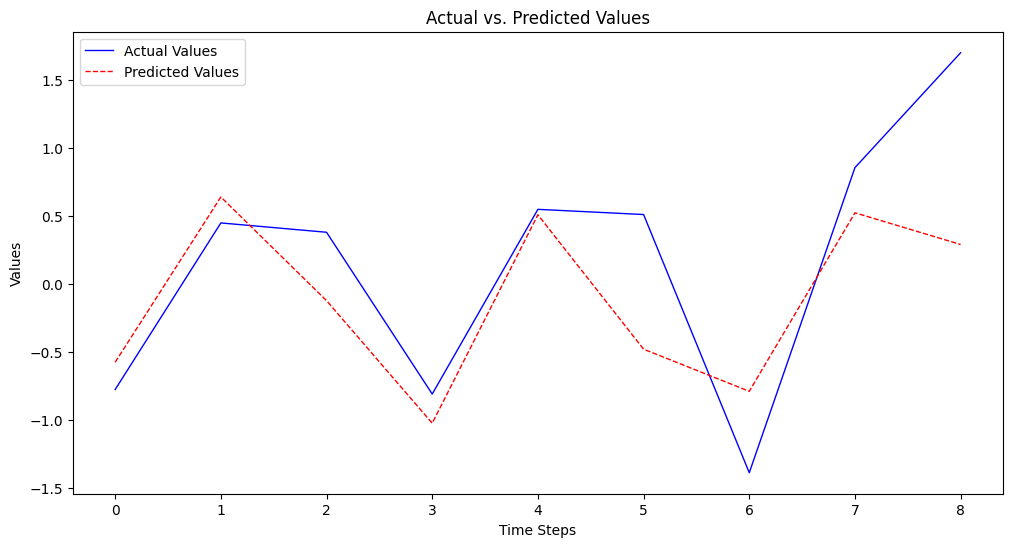

In [76]:
# Predict using the trained RNN model
y_pred = best_model.predict(X_test_seq)
# Print first few values for comparison
print("Actual:", y_test_seq[:5].flatten())
print("Predicted:", y_pred[:5].flatten())
y_test_flat = y_test_seq.flatten()
y_pred_flat = y_pred.flatten()
# Define the range for the x-axis
x_range = range(len(y_test_flat))
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(x_range, y_test_flat, label='Actual Values', color='blue', linestyle='-', linewidth=1)
plt.plot(x_range, y_pred_flat, label='Predicted Values', color='red', linestyle='--', linewidth=1)
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

In [2]:
from sklearn.metrics import mean_squared_error
import numpy as np
y_test_flat = y_test_seq.flatten()
y_pred_flat = y_pred.flatten()

NameError: name 'y_test_seq' is not defined

In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_test_flat, y_pred_flat)
mse = mean_squared_error(y_test_flat, y_pred_flat)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_flat, y_pred)

final_r2 = r2_score(y_test_flat, y_pred_flat)

print('Forecast Accuracy Metrics:')
print(f"Final Model R² Score: {final_r2:.4f}")

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

Forecast Accuracy Metrics:
Final Model R² Score: 0.4897
MAE: 0.49817987611563136
MSE: 0.42456144230392817
RMSE: 0.6515837953048926
MAPE: 0.6587423146806596


# Feature importancE


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
                                              Feature  Importance
0            Banks’ net domestic assets (million AMD)    1.031752
1   High liquidity assets ratio to demand liabilities    0.048428
2                                      Industry Loans    0.022331
3                                   Return on capital    0.022084
4                Demand 

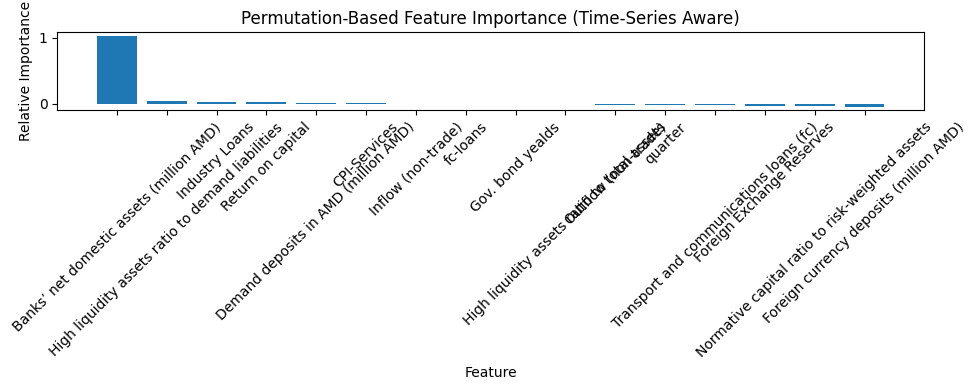

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Get feature names
feature_names = list(X_test.columns.values) if isinstance(X_test, pd.DataFrame) else [f'feature_{i}' for i in range(X_test_seq.shape[2])]

# 1. Baseline prediction
baseline_preds = best_model.predict(X_test_seq)
baseline_mse = mean_squared_error(y_test_seq, baseline_preds)

importances = []

# 2. Loop over features
for feature_idx in range(X_test_seq.shape[2]):
    X_permuted = X_test_seq.copy()

    # 3. Shuffle across samples for each time step, preserving sequence structure
    for t in range(X_test_seq.shape[1]):  # loop through time steps
        temp = X_permuted[:, t, feature_idx].copy()
        np.random.shuffle(temp)
        X_permuted[:, t, feature_idx] = temp

    # 4. Predict with permuted feature
    permuted_preds = best_model.predict(X_permuted)
    permuted_mse = mean_squared_error(y_test_seq, permuted_preds)
    importances.append(permuted_mse - baseline_mse)

# 5. Normalize importances
importances = np.array(importances)
normalized_importances = importances / np.sum(importances)

# 6. Format output
importance_dict = dict(zip(feature_names, normalized_importances))
importance_dict = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))
importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])

# 7. Display results
print(importance_df)

# 8. Plot results
plt.figure(figsize=(10, 4))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.title("Permutation-Based Feature Importance (Time-Series Aware)")
plt.xlabel("Feature")
plt.ylabel("Relative Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
